In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import time

import pickle

## USING PREVIOUS DATA

We want to be able to save thing 

IF PICKLED = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/plots
Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [4]:
from modules.multi_bounds import bounds_class
from modules.tight_knn_func import knn_num_calc


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
sample_sizes = np.logspace(2, 3.3011, 9 , endpoint = True, dtype = int)

sample_sizes

array([ 100,  145,  211,  307,  447,  650,  945, 1375, 2000])

In [6]:
mean_sep = 2.56
# Set the mean and covariance matrix for each Gaussian distribution

mean1 = [0, 0, 0 , 0 , 0, 0, 0 , 0]
# covariance1 = np.ones((3,3))
covariance1 = np.identity(8)
# covariance1 = [[1, 0, 0],  [0, 1, 0], [0, 0, 0]

mean2 = [mean_sep, 0, 0 , 0, 0, 0,0, 0 ]
# mean2 = [math.sqrt(1/2), math.sqrt(1/2), 0]

# covariance2 = np.ones((3,3))
covariance2= np.identity(8)


##### Run the simulation

In [7]:

bound_obj_lst = []
MC_num = 500


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:
    for i in sample_sizes:

        start = time.time()

        n0, n1 = i, i
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]
        
        
        
        k = knn_num_calc(n0, len(mean1))
        tight_params = [5, k ]
        

        
        
        if  i < 750:
            threads =2
        else:
            threads = 4

        bounds = bounds_class("mv_normal", params1, params2, threads =threads,  MC_num = MC_num, tight_params = tight_params )
        
        bound_obj_lst.append(bounds)
        
                
        end = time.time()

        
        
        print("done with ", i, " in ",  end -start )


USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [8]:
file_path = 'sim_data/inc_n.pkl'


if PICKLED  == False:
    objects_to_save = bound_obj_lst

    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst = loaded_objects

Loaded object successfully


## Using simulated data 

In [9]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(a)
    dp_u.append(b)
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(a)
    Bha_u.append(b)

    
    a, b = obj.get_bounds_tight()
    tight_l.append(a)
    tight_u.append(b)

    
    

### Calculate BER and MSE Function

In [10]:
dx = 0.001
x = np.arange(-5, 8 + dx, dx)

f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
f1 = np.exp(-0.5 * (x - mean_sep)**2) / np.sqrt(2 * np.pi)

fmin = np.minimum(f0, f1)

BER = 0.5 * np.sum(fmin * dx)

print("BER 2d:", BER)

BER 2d: 0.10027258671145768


In [11]:
BER_lst = np.ones(MC_num) * BER


def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

### Theoretical values

In [12]:
from modules.Bhattacharyya_func import Bhattacharyya_bounds as Bhattacharyya_bounds_calc

mean1 = np.array(mean1)
mean2 = np.array(mean2)

theory_bha = Bhattacharyya_bounds_calc([mean1, covariance1], [mean2, covariance2])



MATLAB = [.0792, 0.1459]

In [13]:
cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(MC_num) * (theory_bha[0])
bha_theoretical_u= np.ones(MC_num) * (theory_bha[1])


dp_theoretical_l= np.ones(MC_num) * MATLAB[0]
dp_theoretical_u= np.ones(MC_num) * MATLAB[1]


In [14]:
lower_mse_DP = []
upper_mse_DP =[]

lower_mse_Bha = []
upper_mse_Bha =[]

# lower_MSE_tight =[]
# upper_MSE_tight= []


for i in range(len(bound_obj_lst)):
    l_mse = mse(dp_theoretical_l, dp_l[i]) 
    lower_mse_DP.append(l_mse)
    
    u_mse = mse(dp_theoretical_u, dp_u[i]) 
    upper_mse_DP.append(u_mse)       

    
    l_mse = mse(bha_theoretical_l, Bha_l[i]) 
    lower_mse_Bha.append(l_mse)
    
    u_mse = mse(bha_theoretical_u, Bha_u[i])
    upper_mse_Bha.append(u_mse) 
    
#     l_mse =mse(BER_lst, tight_l[i])
#     lower_MSE_tight.append(l_mse)
    
#     u_mse =mse(BER_lst, tight_u[i])
#     lower_MSE_tight.append(u_mse)

### Plotting

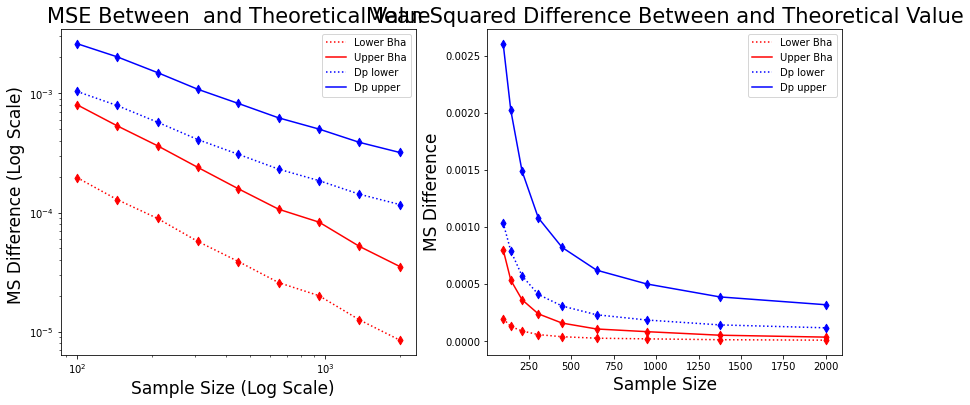

In [51]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r:', label='Lower Bha')
ax.plot(sample_sizes, upper_mse_Bha,'r-', label='Upper Bha')

ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_DP,  'b:', label='Dp lower')
ax.plot(sample_sizes, upper_mse_DP,  'b-', label='Dp upper')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
ax.set_title("MSE Between  and Theoretical Value", fontsize = fs +4)


ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')
ax.legend()

ax = axes[1]


ax.plot(sample_sizes, lower_mse_Bha,'r:', label='Lower Bha')
ax.plot(sample_sizes, upper_mse_Bha,'r-', label='Upper Bha')

ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_DP,  'b:', label='Dp lower')
ax.plot(sample_sizes, upper_mse_DP,  'b-', label='Dp upper')

ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')

ax.set_xlabel("Sample Size", fontsize = fs)
ax.set_ylabel("MS Difference", fontsize=fs)
ax.set_title("Mean Squared Difference Between and Theoretical Value", fontsize = fs +4)

ax.legend()

# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)
plt.show()


In [31]:
validity_dp_l = np.zeros(len(sample_sizes))
validity_dp_u = np.zeros(len(sample_sizes))

validity_Bha_l = np.zeros(len(sample_sizes))
validity_Bha_u =  np.zeros(len(sample_sizes))

validity_tight_l = np.zeros(len(sample_sizes))
validity_tight_u =  np.zeros(len(sample_sizes))

for i in range(len(sample_sizes)):
#     Bha_l, Bha_u = Bha_lst[i].get_bounds()
#     dp_l, dp_u = dp_lst[i].get_bounds()
    for j in range(MC_num):
        if Bha_l[i][j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u[i][j] > BER:
            validity_Bha_u[i] += 1
    
        if dp_l[i][j] < BER:
            validity_dp_l[i] += 1
        if dp_u[i][j] > BER:
            validity_dp_u[i] += 1
        if tight_l[i][j] < BER:
            validity_tight_l[i] += 1
        if tight_u[i][j]> BER:
            validity_tight_u[i] += 1

        

In [32]:
print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

[246. 258. 288. 327. 390. 416. 462. 487. 497.] [498. 500. 500. 500. 500. 500. 500. 500. 500.] [498. 500. 500. 500. 500. 500. 500. 500. 500.] [500. 500. 500. 500. 500. 500. 500. 500. 500.] [16. 16.  2.  0.  0.  0.  0.  0.  0.] [500. 500. 500. 500. 500. 500. 500. 500. 500.]


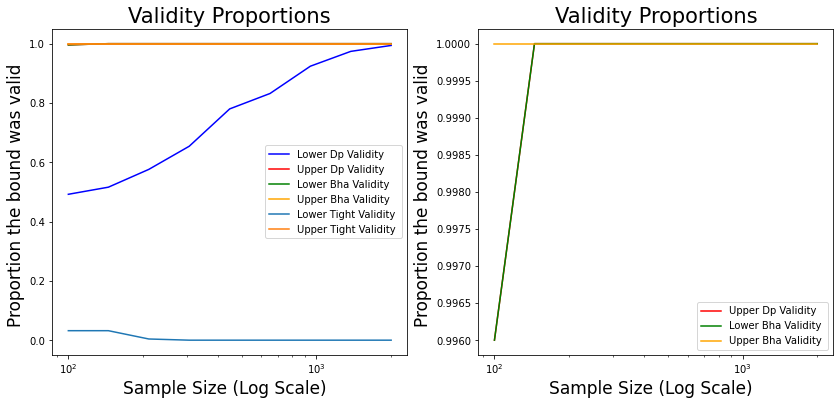

In [18]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.plot(sample_sizes, validity_tight_l/ MC_num, label='Lower Tight Validity ')
ax.plot(sample_sizes, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

# ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()